# Abstract "Translation"
In the original project, I trained a sequence to sequence model on a dataset of English and French sentences that can translate new sentences from English to French. This notebook was modified such that abstracts became the English text and the titles became the French text. The abstracts are defined as the source_text and the titles are defined as the target_text
## Get the Data
The data comes from the discovery set made by Roxana and Diego. The abstracts and titles were further cleaned as shown in another notebook.

In [30]:
import pandas as pd
data = pd.read_csv('cleaner_abstracts_titles.csv')

In [31]:
abstracts = data.abstracts #helper.load_data(source_path)
titles = data.titles #helper.load_data(target_path)

with open('titles.txt', 'w+') as file:
    for title in titles:
        file.write(title+'\n')
    file.close()
    
with open('abstracts.txt', 'w+') as file:
    for abstract in abstracts:
        file.write(abstract+'\n')
    file.close()

In [32]:
import helper
import problem_unittests as tests
source_path = 'abstracts.txt'
target_path = 'titles.txt'
source_text = helper.load_data(source_path)
target_text = helper.load_data(target_path)


## Explore the Data
Feel free to play around with view_sentence_range to view different parts of the data.

In [33]:
view_sentence_range = (0, 10)

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

print('Dataset Stats')
print('Roughly the number of unique words: {}'.format(len({word: None for word in source_text.split()})))

sentences = source_text.split('\n')
word_counts = [len(sentence.split()) for sentence in sentences]
print('Number of abstracts: {}'.format(len(sentences)))
print('Average number of words in an abstract: {}'.format(np.average(word_counts)))

print()
print('Abstracts {} to {}:'.format(*view_sentence_range))
print('\n'.join(source_text.split('\n')[view_sentence_range[0]:view_sentence_range[1]]))
print()
print('Titles {} to {}:'.format(*view_sentence_range))
print('\n'.join(target_text.split('\n')[view_sentence_range[0]:view_sentence_range[1]]))

Dataset Stats
Roughly the number of unique words: 19188
Number of abstracts: 4965
Average number of words in an abstract: 201.70231621349447

Abstracts 0 to 10:
we present an ultra deep survey for neptun trojan use the subaru m and magellan m telescop the survey reach a detect effici in the r band at magnitud and cover squar degre of sky thi depth correspond to neptun trojan that are about km in radiu assum an albedo of a pauciti of smaller neptun trojan radiu km compar to larger one wa found the brightest neptun trojan appear to follow a steep power law slope q similar to the brightest object in the other known stabl reservoir such a the kuiper belt, jupit trojan and main belt asteroid we find a roll over for the neptun trojan that occur around a radiu of r km mags, which is also veri similar to the other stabl reservoir all the observ stabl region in the the solar system show evid for miss intermedi size planetesim misp thi indic a primordi and not collision origin, which suggest pla

## Implement Preprocessing Function
### Text to Word Ids
As you did with other RNNs, you must turn the text into a number so the computer can understand it. In the function `text_to_ids()`, you'll turn `source_text` and `target_text` from words to ids.  However, you need to add the `<EOS>` word id at the end of `target_text`.  This will help the neural network predict when the sentence should end.

You can get the `<EOS>` word id by doing:
```python
target_vocab_to_int['<EOS>']
```
You can get other word ids using `source_vocab_to_int` and `target_vocab_to_int`.

In [34]:
def text_to_ids(source_text, target_text, source_vocab_to_int, target_vocab_to_int):
    """
    Convert source and target text to proper word ids
    :param source_text: String that contains all the source text.
    :param target_text: String that contains all the target text.
    :param source_vocab_to_int: Dictionary to go from the source words to an id
    :param target_vocab_to_int: Dictionary to go from the target words to an id
    :return: A tuple of lists (source_id_text, target_id_text)
    """
    # TODO: Implement Function
    source_id_text = [[source_vocab_to_int[word] for word in sentence.split()] \
                      for sentence in source_text.split('\n')] 
    target_id_text = [[target_vocab_to_int[word] for word in sentence.split()] + [target_vocab_to_int['<EOS>']] \
                      for sentence in target_text.split('\n')]
    return source_id_text, target_id_text

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_text_to_ids(text_to_ids)

Tests Passed


### Preprocess all the data and save it
Running the code cell below will preprocess all the data and save it to file.

In [35]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
helper.preprocess_and_save_data(source_path, target_path, text_to_ids)

# Check Point
This is your first checkpoint. If you ever decide to come back to this notebook or have to restart the notebook, you can start from here. The preprocessed data has been saved to disk.

In [36]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np
import helper

(source_int_text, target_int_text), (source_vocab_to_int, target_vocab_to_int), _ = helper.load_preprocess()

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [37]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf
from tensorflow.python.layers.core import Dense

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.1'), 'Please use TensorFlow version 1.1 or newer'
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


## Build the Neural Network
You'll build the components necessary to build a Sequence-to-Sequence model by implementing the following functions below:
- `model_inputs`
- `process_decoder_input`
- `encoding_layer`
- `decoding_layer_train`
- `decoding_layer_infer`
- `decoding_layer`
- `seq2seq_model`

### Input
Implement the `model_inputs()` function to create TF Placeholders for the Neural Network. It should create the following placeholders:

- Input text placeholder named "input" using the TF Placeholder name parameter with rank 2.
- Targets placeholder with rank 2.
- Learning rate placeholder with rank 0.
- Keep probability placeholder named "keep_prob" using the TF Placeholder name parameter with rank 0.
- Target sequence length placeholder named "target_sequence_length" with rank 1
- Max target sequence length tensor named "max_target_len" getting its value from applying tf.reduce_max on the target_sequence_length placeholder. Rank 0.
- Source sequence length placeholder named "source_sequence_length" with rank 1

Return the placeholders in the following the tuple (input, targets, learning rate, keep probability, target sequence length, max target sequence length, source sequence length)

In [38]:
def model_inputs():
    """
    Create TF Placeholders for input, targets, learning rate, and lengths of source and target sequences.
    :return: Tuple (input, targets, learning rate, keep probability, target sequence length,
    max target sequence length, source sequence length)
    """
    inputs = tf.placeholder(tf.int32, [None, None], name='input')
    
    targets = tf.placeholder(tf.int32, [None, None])
    
    learning_rate = tf.placeholder(tf.float32)
    
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    
    target_sequence_length = tf.placeholder(tf.int32, [None], name='target_sequence_length')
    
    max_target_len = tf.reduce_max(target_sequence_length, name='max_target_len')
    
    source_sequence_length = tf.placeholder(tf.int32, [None],name='source_sequence_length')
    
    return inputs, targets, learning_rate, keep_prob, target_sequence_length, max_target_len, source_sequence_length


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Process Decoder Input
Implement `process_decoder_input` by removing the last word id from each batch in `target_data` and concat the GO ID to the begining of each batch.

In [39]:
def process_decoder_input(target_data, target_vocab_to_int, batch_size):
    """
    Preprocess target data for encoding
    :param target_data: Target Placehoder
    :param target_vocab_to_int: Dictionary to go from the target words to an id
    :param batch_size: Batch Size
    :return: Preprocessed target data
    """
    ending = tf.strided_slice(target_data, [0, 0], [batch_size, -1], [1, 1])
    
    proc_input = tf.concat([tf.fill([batch_size, 1], target_vocab_to_int['<GO>']), ending], 1)
    
    return proc_input

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_process_encoding_input(process_decoder_input)

Tests Passed


### Encoding
Implement `encoding_layer()` to create a Encoder RNN layer:
 * Embed the encoder input using [`tf.contrib.layers.embed_sequence`](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/embed_sequence)
 * Construct a [stacked](https://github.com/tensorflow/tensorflow/blob/6947f65a374ebf29e74bb71e36fd82760056d82c/tensorflow/docs_src/tutorials/recurrent.md#stacking-multiple-lstms) [`tf.contrib.rnn.LSTMCell`](https://www.tensorflow.org/api_docs/python/tf/contrib/rnn/LSTMCell) wrapped in a [`tf.contrib.rnn.DropoutWrapper`](https://www.tensorflow.org/api_docs/python/tf/contrib/rnn/DropoutWrapper)
 * Pass cell and embedded input to [`tf.nn.dynamic_rnn()`](https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn)

In [40]:
from imp import reload
reload(tests)

def encoding_layer(rnn_inputs, rnn_size, num_layers, keep_prob, 
                   source_sequence_length, source_vocab_size, 
                   encoding_embedding_size):
    """
    Create encoding layer
    :param rnn_inputs: Inputs for the RNN
    :param rnn_size: RNN Size
    :param num_layers: Number of layers
    :param keep_prob: Dropout keep probability
    :param source_sequence_length: a list of the lengths of each sequence in the batch
    :param source_vocab_size: vocabulary size of source data
    :param encoding_embedding_size: embedding size of source data
    :return: tuple (RNN output, RNN state)
    """
    embedded_input = tf.contrib.layers.embed_sequence(rnn_inputs, 
                                                      source_vocab_size, 
                                                      encoding_embedding_size)
    
    cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(rnn_size) \
                                        for _ in range(num_layers)])
    
    cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
    
    output, state = tf.nn.dynamic_rnn(cell, embedded_input, 
                                      sequence_length=source_sequence_length, dtype=tf.float32)
    
    return output, state

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_encoding_layer(encoding_layer)

Tests Passed


### Decoding - Training
Create a training decoding layer:
* Create a [`tf.contrib.seq2seq.TrainingHelper`](https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/TrainingHelper) 
* Create a [`tf.contrib.seq2seq.BasicDecoder`](https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/BasicDecoder)
* Obtain the decoder outputs from [`tf.contrib.seq2seq.dynamic_decode`](https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/dynamic_decode)

In [41]:

def decoding_layer_train(encoder_state, dec_cell, dec_embed_input, 
                         target_sequence_length, max_summary_length, 
                         output_layer, keep_prob):
    """
    Create a decoding layer for training
    :param encoder_state: Encoder State
    :param dec_cell: Decoder RNN Cell
    :param dec_embed_input: Decoder embedded input
    :param target_sequence_length: The lengths of each sequence in the target batch
    :param max_summary_length: The length of the longest sequence in the batch
    :param output_layer: Function to apply the output layer
    :param keep_prob: Dropout keep probability
    :return: BasicDecoderOutput containing training logits and sample_id
    """
    ##1. Apply TrainingHelper
    train_helper = tf.contrib.seq2seq.TrainingHelper(inputs=dec_embed_input,
                                                    sequence_length=target_sequence_length,
                                                    time_major=False)
    
    ##2. Apply BasicDecoder
    train_decode = tf.contrib.seq2seq.BasicDecoder(dec_cell,
                                                 train_helper,
                                                 encoder_state,
                                                 output_layer)
    
    ##3. Apply dynamic_decode
    train_decode_output, _ = tf.contrib.seq2seq.dynamic_decode(train_decode,
                                                              impute_finished=True,
                                                              maximum_iterations=max_summary_length)
    
    return train_decode_output



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_decoding_layer_train(decoding_layer_train)

Tests Passed


### Decoding - Inference
Create inference decoder:
* Create a [`tf.contrib.seq2seq.GreedyEmbeddingHelper`](https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/GreedyEmbeddingHelper)
* Create a [`tf.contrib.seq2seq.BasicDecoder`](https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/BasicDecoder)
* Obtain the decoder outputs from [`tf.contrib.seq2seq.dynamic_decode`](https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/dynamic_decode)

In [42]:
def decoding_layer_infer(encoder_state, dec_cell, dec_embeddings, start_of_sequence_id,
                         end_of_sequence_id, max_target_sequence_length,
                         vocab_size, output_layer, batch_size, keep_prob):
    """
    Create a decoding layer for inference
    :param encoder_state: Encoder state
    :param dec_cell: Decoder RNN Cell
    :param dec_embeddings: Decoder embeddings
    :param start_of_sequence_id: GO ID
    :param end_of_sequence_id: EOS Id
    :param max_target_sequence_length: Maximum length of target sequences
    :param vocab_size: Size of decoder/target vocabulary
    :param decoding_scope: TenorFlow Variable Scope for decoding
    :param output_layer: Function to apply the output layer
    :param batch_size: Batch size
    :param keep_prob: Dropout keep probability
    :return: BasicDecoderOutput containing inference logits and sample_id
    """
    ##O. Create start tokens
    start_tokens = tf.tile(tf.constant([start_of_sequence_id], dtype=tf.int32),
                          [batch_size], name='start_tokens')
    
    ##1. Apply GreedyEmbeddingHelper
    infer_help = tf.contrib.seq2seq.GreedyEmbeddingHelper(dec_embeddings,
                                                         start_tokens,
                                                         end_of_sequence_id)
    
    ##2. Apply BasicDecoder
    infer_decode = tf.contrib.seq2seq.BasicDecoder(dec_cell, infer_help,
                                                  encoder_state, output_layer)
    
    ##3. Apply dynamic_decode
    infer_decode_output, _ = tf.contrib.seq2seq.dynamic_decode(infer_decode,
                                                              impute_finished=True,
                                                              maximum_iterations=max_target_sequence_length)
    
    return infer_decode_output



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_decoding_layer_infer(decoding_layer_infer)

Tests Passed


### Build the Decoding Layer
Implement `decoding_layer()` to create a Decoder RNN layer.

* Embed the target sequences
* Construct the decoder LSTM cell (just like you constructed the encoder cell above)
* Create an output layer to map the outputs of the decoder to the elements of our vocabulary
* Use the your `decoding_layer_train(encoder_state, dec_cell, dec_embed_input, target_sequence_length, max_target_sequence_length, output_layer, keep_prob)` function to get the training logits.
* Use your `decoding_layer_infer(encoder_state, dec_cell, dec_embeddings, start_of_sequence_id, end_of_sequence_id, max_target_sequence_length, vocab_size, output_layer, batch_size, keep_prob)` function to get the inference logits.

Note: You'll need to use [tf.variable_scope](https://www.tensorflow.org/api_docs/python/tf/variable_scope) to share variables between training and inference.

In [64]:
def decoding_layer(dec_input, encoder_state,
                   target_sequence_length, max_target_sequence_length,
                   rnn_size,
                   num_layers, target_vocab_to_int, target_vocab_size,
                   batch_size, keep_prob, decoding_embedding_size):
    """
    Create decoding layer
    :param dec_input: Decoder input
    :param encoder_state: Encoder state
    :param target_sequence_length: The lengths of each sequence in the target batch
    :param max_target_sequence_length: Maximum length of target sequences
    :param rnn_size: RNN Size
    :param num_layers: Number of layers
    :param target_vocab_to_int: Dictionary to go from the target words to an id
    :param target_vocab_size: Size of target vocabulary
    :param batch_size: The size of the batch
    :param keep_prob: Dropout keep probability
    :param decoding_embedding_size: Decoding embedding size
    :return: Tuple of (Training BasicDecoderOutput, Inference BasicDecoderOutput)
    """
    ##1. Embedded the target sequence
    dec_embeddings = tf.Variable(tf.random_uniform([target_vocab_size, decoding_embedding_size]))
    
    dec_embed_input = tf.nn.embedding_lookup(dec_embeddings, dec_input)
    
    ##2. Construct LSTM Cell
    dec_cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(rnn_size) \
                                            for _ in range(num_layers)])
    
    dec_cell = tf.contrib.rnn.DropoutWrapper(dec_cell, output_keep_prob=keep_prob)
    
    ##3. Create mapping outpult layer
    output_layer = Dense(target_vocab_size, 
                       kernel_initializer = tf.truncated_normal_initializer(mean=0.0, stddev=0.1))
    
    ##4. Do the decoding for training and inference
    with tf.variable_scope('decode'):
        train_decode_output = decoding_layer_train(encoder_state, dec_cell, dec_embed_input, 
                                                  target_sequence_length, max_target_sequence_length, 
                                                  output_layer, keep_prob)
        
    with tf.variable_scope('decode', reuse=True):
        infer_decode_output = decoding_layer_infer(encoder_state, dec_cell, dec_embeddings, 
                                                  target_vocab_to_int['<GO>'], 
                                                  target_vocab_to_int['<EOS>'], 
                                                  max_target_sequence_length, target_vocab_size, output_layer, 
                                                  batch_size, keep_prob)
    
    return train_decode_output, infer_decode_output, dec_embeddings



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
#tests.test_decoding_layer(decoding_layer)

"\nDON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE\n"

### Build the Neural Network
Apply the functions you implemented above to:

- Encode the input using your `encoding_layer(rnn_inputs, rnn_size, num_layers, keep_prob,  source_sequence_length, source_vocab_size, encoding_embedding_size)`.
- Process target data using your `process_decoder_input(target_data, target_vocab_to_int, batch_size)` function.
- Decode the encoded input using your `decoding_layer(dec_input, enc_state, target_sequence_length, max_target_sentence_length, rnn_size, num_layers, target_vocab_to_int, target_vocab_size, batch_size, keep_prob, dec_embedding_size)` function.

In [66]:
def seq2seq_model(input_data, target_data, keep_prob, batch_size,
                  source_sequence_length, target_sequence_length,
                  max_target_sentence_length,
                  source_vocab_size, target_vocab_size,
                  enc_embedding_size, dec_embedding_size,
                  rnn_size, num_layers, target_vocab_to_int):
    """
    Build the Sequence-to-Sequence part of the neural network
    :param input_data: Input placeholder
    :param target_data: Target placeholder
    :param keep_prob: Dropout keep probability placeholder
    :param batch_size: Batch Size
    :param source_sequence_length: Sequence Lengths of source sequences in the batch
    :param target_sequence_length: Sequence Lengths of target sequences in the batch
    :param source_vocab_size: Source vocabulary size
    :param target_vocab_size: Target vocabulary size
    :param enc_embedding_size: Decoder embedding size
    :param dec_embedding_size: Encoder embedding size
    :param rnn_size: RNN Size
    :param num_layers: Number of layers
    :param target_vocab_to_int: Dictionary to go from the target words to an id
    :return: Tuple of (Training BasicDecoderOutput, Inference BasicDecoderOutput)
    """
    ##1. Encode input using enconding_layer()
    _, enc_input = encoding_layer(input_data, rnn_size, num_layers, keep_prob,  
                                   source_sequence_length, source_vocab_size, 
                                   enc_embedding_size)
    
    ##2. Process target data with procesed_decoder_input()
    dec_input = process_decoder_input(target_data, target_vocab_to_int, batch_size)
    
    ##3. Decode input using decoding_layer
    train_output, infer_output, dec_embeddings = decoding_layer(dec_input, enc_input, target_sequence_length, 
                                                max_target_sentence_length, rnn_size, num_layers, 
                                                target_vocab_to_int, target_vocab_size, batch_size, 
                                                keep_prob, dec_embedding_size)
    
    return train_output, infer_output, dec_embeddings


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
#tests.test_seq2seq_model(seq2seq_model)

"\nDON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE\n"

## Neural Network Training
### Hyperparameters
Tune the following parameters:

- Set `epochs` to the number of epochs.
- Set `batch_size` to the batch size.
- Set `rnn_size` to the size of the RNNs.
- Set `num_layers` to the number of layers.
- Set `encoding_embedding_size` to the size of the embedding for the encoder.
- Set `decoding_embedding_size` to the size of the embedding for the decoder.
- Set `learning_rate` to the learning rate.
- Set `keep_probability` to the Dropout keep probability
- Set `display_step` to state how many steps between each debug output statement

In [79]:
# Number of Epochs
epochs = 48*4
# Batch Size
batch_size = 128
# RNN Size
rnn_size = 300
# Number of Layers
num_layers = 4
# Embedding Size
encoding_embedding_size = 130
decoding_embedding_size = 130
# Learning Rate
learning_rate = 0.001
# Dropout Keep Probability
keep_probability = 0.8
display_step = 10

### Build the Graph
Build the graph using the neural network you implemented.

In [80]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
save_path = 'checkpoints/dev'
(source_int_text, target_int_text), (source_vocab_to_int, target_vocab_to_int), _ = helper.load_preprocess()
max_target_sentence_length = max([len(sentence) for sentence in source_int_text])

train_graph = tf.Graph()
with train_graph.as_default():
    input_data, targets, lr, keep_prob, target_sequence_length, max_target_sequence_length, source_sequence_length = model_inputs()

    #sequence_length = tf.placeholder_with_default(max_target_sentence_length, None, name='sequence_length')
    input_shape = tf.shape(input_data)

    train_logits, inference_logits, dec_embeddings = seq2seq_model(tf.reverse(input_data, [-1]),
                                                   targets,
                                                   keep_prob,
                                                   batch_size,
                                                   source_sequence_length,
                                                   target_sequence_length,
                                                   max_target_sequence_length,
                                                   len(source_vocab_to_int),
                                                   len(target_vocab_to_int),
                                                   encoding_embedding_size,
                                                   decoding_embedding_size,
                                                   rnn_size,
                                                   num_layers,
                                                   target_vocab_to_int)


    training_logits = tf.identity(train_logits.rnn_output, name='logits')
    inference_logits = tf.identity(inference_logits.sample_id, name='predictions')

    masks = tf.sequence_mask(target_sequence_length, max_target_sequence_length, dtype=tf.float32, name='masks')

    with tf.name_scope("optimization"):
        # Loss function
        cost = tf.contrib.seq2seq.sequence_loss(
            training_logits,
            targets,
            masks)

        # Optimizer
        optimizer = tf.train.AdamOptimizer(lr)

        # Gradient Clipping
        gradients = optimizer.compute_gradients(cost)
        capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients if grad is not None]
        train_op = optimizer.apply_gradients(capped_gradients)


Batch and pad the source and target sequences

In [81]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
def pad_sentence_batch(sentence_batch, pad_int):
    """Pad sentences with <PAD> so that each sentence of a batch has the same length"""
    max_sentence = max([len(sentence) for sentence in sentence_batch])
    return [sentence + [pad_int] * (max_sentence - len(sentence)) for sentence in sentence_batch]


def get_batches(sources, targets, batch_size, source_pad_int, target_pad_int):
    """Batch targets, sources, and the lengths of their sentences together"""
    for batch_i in range(0, len(sources)//batch_size):
        start_i = batch_i * batch_size

        # Slice the right amount for the batch
        sources_batch = sources[start_i:start_i + batch_size]
        targets_batch = targets[start_i:start_i + batch_size]

        # Pad
        pad_sources_batch = np.array(pad_sentence_batch(sources_batch, source_pad_int))
        pad_targets_batch = np.array(pad_sentence_batch(targets_batch, target_pad_int))

        # Need the lengths for the _lengths parameters
        pad_targets_lengths = []
        for target in pad_targets_batch:
            pad_targets_lengths.append(len(target))

        pad_source_lengths = []
        for source in pad_sources_batch:
            pad_source_lengths.append(len(source))

        yield pad_sources_batch, pad_targets_batch, pad_source_lengths, pad_targets_lengths


### Train
Train the neural network on the preprocessed data. If you have a hard time getting a good loss, check the forms to see if anyone is having the same problem.

In [82]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
def get_accuracy(target, logits):
    """
    Calculate accuracy
    """
    max_seq = max(target.shape[1], logits.shape[1])
    if max_seq - target.shape[1]:
        target = np.pad(
            target,
            [(0,0),(0,max_seq - target.shape[1])],
            'constant')
    if max_seq - logits.shape[1]:
        logits = np.pad(
            logits,
            [(0,0),(0,max_seq - logits.shape[1])],
            'constant')

    return np.mean(np.equal(target, logits))

# Split data to training and validation sets
train_source = source_int_text[batch_size:]
train_target = target_int_text[batch_size:]
valid_source = source_int_text[:batch_size]
valid_target = target_int_text[:batch_size]
(valid_sources_batch, valid_targets_batch, valid_sources_lengths, valid_targets_lengths ) = next(get_batches(valid_source,
                                                                                                             valid_target,
                                                                                                             batch_size,
                                                                                                             source_vocab_to_int['<PAD>'],
                                                                                                             target_vocab_to_int['<PAD>']))                                                                                                  
with tf.Session(graph=train_graph) as sess:
    sess.run(tf.global_variables_initializer())

    for epoch_i in range(epochs):
        for batch_i, (source_batch, target_batch, sources_lengths, targets_lengths) in enumerate(
                get_batches(train_source, train_target, batch_size,
                            source_vocab_to_int['<PAD>'],
                            target_vocab_to_int['<PAD>'])):

            _, loss = sess.run(
                [train_op, cost],
                {input_data: source_batch,
                 targets: target_batch,
                 lr: learning_rate,
                 target_sequence_length: targets_lengths,
                 source_sequence_length: sources_lengths,
                 keep_prob: keep_probability})


            if batch_i % display_step == 0 and batch_i > 0:


                batch_train_logits = sess.run(
                    inference_logits,
                    {input_data: source_batch,
                     source_sequence_length: sources_lengths,
                     target_sequence_length: targets_lengths,
                     keep_prob: 1.0})


                batch_valid_logits = sess.run(
                    inference_logits,
                    {input_data: valid_sources_batch,
                     source_sequence_length: valid_sources_lengths,
                     target_sequence_length: valid_targets_lengths,
                     keep_prob: 1.0})

                train_acc = get_accuracy(target_batch, batch_train_logits)

                valid_acc = get_accuracy(valid_targets_batch, batch_valid_logits)

                print('Epoch {:>3} Batch {:>4}/{} - Train Accuracy: {:>6.4f}, Validation Accuracy: {:>6.4f}, Loss: {:>6.4f}'
                      .format(epoch_i, batch_i, len(source_int_text) // batch_size, train_acc, valid_acc, loss))

    # Save Model
    saver = tf.train.Saver()
    saver.save(sess, save_path)
    print('Model Trained and Saved')

Epoch   0 Batch   10/38 - Train Accuracy: 0.4897, Validation Accuracy: 0.4888, Loss: 4.2683
Epoch   0 Batch   20/38 - Train Accuracy: 0.4513, Validation Accuracy: 0.4981, Loss: 3.9643
Epoch   0 Batch   30/38 - Train Accuracy: 0.5446, Validation Accuracy: 0.5006, Loss: 3.3090
Epoch   1 Batch   10/38 - Train Accuracy: 0.4981, Validation Accuracy: 0.4969, Loss: 3.5043
Epoch   1 Batch   20/38 - Train Accuracy: 0.4506, Validation Accuracy: 0.5006, Loss: 3.7509
Epoch   1 Batch   30/38 - Train Accuracy: 0.5443, Validation Accuracy: 0.4997, Loss: 3.2270
Epoch   2 Batch   10/38 - Train Accuracy: 0.5016, Validation Accuracy: 0.4988, Loss: 3.4976
Epoch   2 Batch   20/38 - Train Accuracy: 0.4521, Validation Accuracy: 0.4984, Loss: 3.7341
Epoch   2 Batch   30/38 - Train Accuracy: 0.5422, Validation Accuracy: 0.4991, Loss: 3.2105
Epoch   3 Batch   10/38 - Train Accuracy: 0.5034, Validation Accuracy: 0.5000, Loss: 3.4402
Epoch   3 Batch   20/38 - Train Accuracy: 0.4517, Validation Accuracy: 0.5022, L

Epoch  30 Batch   10/38 - Train Accuracy: 0.4784, Validation Accuracy: 0.4678, Loss: 2.3954
Epoch  30 Batch   20/38 - Train Accuracy: 0.4116, Validation Accuracy: 0.4484, Loss: 2.5363
Epoch  30 Batch   30/38 - Train Accuracy: 0.5194, Validation Accuracy: 0.4622, Loss: 2.2186
Epoch  31 Batch   10/38 - Train Accuracy: 0.4784, Validation Accuracy: 0.4709, Loss: 2.3625
Epoch  31 Batch   20/38 - Train Accuracy: 0.4183, Validation Accuracy: 0.4581, Loss: 2.4583
Epoch  31 Batch   30/38 - Train Accuracy: 0.5246, Validation Accuracy: 0.4672, Loss: 2.1811
Epoch  32 Batch   10/38 - Train Accuracy: 0.4831, Validation Accuracy: 0.4734, Loss: 2.3147
Epoch  32 Batch   20/38 - Train Accuracy: 0.4201, Validation Accuracy: 0.4534, Loss: 2.4170
Epoch  32 Batch   30/38 - Train Accuracy: 0.5133, Validation Accuracy: 0.4434, Loss: 2.1472
Epoch  33 Batch   10/38 - Train Accuracy: 0.4750, Validation Accuracy: 0.4747, Loss: 2.2615
Epoch  33 Batch   20/38 - Train Accuracy: 0.4261, Validation Accuracy: 0.4509, L

Epoch  60 Batch   10/38 - Train Accuracy: 0.4803, Validation Accuracy: 0.4516, Loss: 1.6967
Epoch  60 Batch   20/38 - Train Accuracy: 0.4290, Validation Accuracy: 0.4491, Loss: 1.7130
Epoch  60 Batch   30/38 - Train Accuracy: 0.5223, Validation Accuracy: 0.4541, Loss: 1.6042
Epoch  61 Batch   10/38 - Train Accuracy: 0.4875, Validation Accuracy: 0.4622, Loss: 1.6455
Epoch  61 Batch   20/38 - Train Accuracy: 0.4151, Validation Accuracy: 0.4225, Loss: 1.6817
Epoch  61 Batch   30/38 - Train Accuracy: 0.5321, Validation Accuracy: 0.4603, Loss: 1.5877
Epoch  62 Batch   10/38 - Train Accuracy: 0.4888, Validation Accuracy: 0.4669, Loss: 1.6324
Epoch  62 Batch   20/38 - Train Accuracy: 0.4237, Validation Accuracy: 0.4453, Loss: 1.6562
Epoch  62 Batch   30/38 - Train Accuracy: 0.5255, Validation Accuracy: 0.4572, Loss: 1.5290
Epoch  63 Batch   10/38 - Train Accuracy: 0.4763, Validation Accuracy: 0.4522, Loss: 1.6308
Epoch  63 Batch   20/38 - Train Accuracy: 0.4258, Validation Accuracy: 0.4562, L

Epoch  90 Batch   10/38 - Train Accuracy: 0.5747, Validation Accuracy: 0.4131, Loss: 0.9954
Epoch  90 Batch   20/38 - Train Accuracy: 0.6030, Validation Accuracy: 0.4550, Loss: 0.9446
Epoch  90 Batch   30/38 - Train Accuracy: 0.6016, Validation Accuracy: 0.4472, Loss: 0.9877
Epoch  91 Batch   10/38 - Train Accuracy: 0.5897, Validation Accuracy: 0.4147, Loss: 0.9810
Epoch  91 Batch   20/38 - Train Accuracy: 0.6097, Validation Accuracy: 0.4541, Loss: 0.9255
Epoch  91 Batch   30/38 - Train Accuracy: 0.5885, Validation Accuracy: 0.4416, Loss: 0.9627
Epoch  92 Batch   10/38 - Train Accuracy: 0.5856, Validation Accuracy: 0.4363, Loss: 0.9550
Epoch  92 Batch   20/38 - Train Accuracy: 0.6317, Validation Accuracy: 0.4444, Loss: 0.8633
Epoch  92 Batch   30/38 - Train Accuracy: 0.6126, Validation Accuracy: 0.4313, Loss: 0.9201
Epoch  93 Batch   10/38 - Train Accuracy: 0.5991, Validation Accuracy: 0.4472, Loss: 0.9518
Epoch  93 Batch   20/38 - Train Accuracy: 0.6325, Validation Accuracy: 0.4363, L

Epoch 120 Batch   10/38 - Train Accuracy: 0.7459, Validation Accuracy: 0.4587, Loss: 0.5642
Epoch 120 Batch   20/38 - Train Accuracy: 0.8015, Validation Accuracy: 0.4372, Loss: 0.5291
Epoch 120 Batch   30/38 - Train Accuracy: 0.7659, Validation Accuracy: 0.4100, Loss: 0.5318
Epoch 121 Batch   10/38 - Train Accuracy: 0.7966, Validation Accuracy: 0.4669, Loss: 0.4592
Epoch 121 Batch   20/38 - Train Accuracy: 0.8466, Validation Accuracy: 0.4309, Loss: 0.4402
Epoch 121 Batch   30/38 - Train Accuracy: 0.7940, Validation Accuracy: 0.4375, Loss: 0.4816
Epoch 122 Batch   10/38 - Train Accuracy: 0.8078, Validation Accuracy: 0.4637, Loss: 0.4386
Epoch 122 Batch   20/38 - Train Accuracy: 0.8633, Validation Accuracy: 0.4328, Loss: 0.4444
Epoch 122 Batch   30/38 - Train Accuracy: 0.7867, Validation Accuracy: 0.4359, Loss: 0.4729
Epoch 123 Batch   10/38 - Train Accuracy: 0.8163, Validation Accuracy: 0.4656, Loss: 0.4590
Epoch 123 Batch   20/38 - Train Accuracy: 0.8590, Validation Accuracy: 0.4547, L

Epoch 150 Batch   10/38 - Train Accuracy: 0.9862, Validation Accuracy: 0.4566, Loss: 0.1197
Epoch 150 Batch   20/38 - Train Accuracy: 0.9989, Validation Accuracy: 0.4569, Loss: 0.0952
Epoch 150 Batch   30/38 - Train Accuracy: 0.9913, Validation Accuracy: 0.4400, Loss: 0.1320
Epoch 151 Batch   10/38 - Train Accuracy: 0.9872, Validation Accuracy: 0.4522, Loss: 0.1141
Epoch 151 Batch   20/38 - Train Accuracy: 1.0000, Validation Accuracy: 0.4472, Loss: 0.0975
Epoch 151 Batch   30/38 - Train Accuracy: 0.9867, Validation Accuracy: 0.4475, Loss: 0.1316
Epoch 152 Batch   10/38 - Train Accuracy: 0.9969, Validation Accuracy: 0.4544, Loss: 0.1038
Epoch 152 Batch   20/38 - Train Accuracy: 1.0000, Validation Accuracy: 0.4547, Loss: 0.0895
Epoch 152 Batch   30/38 - Train Accuracy: 0.9919, Validation Accuracy: 0.4356, Loss: 0.1207
Epoch 153 Batch   10/38 - Train Accuracy: 0.9950, Validation Accuracy: 0.4356, Loss: 0.1091
Epoch 153 Batch   20/38 - Train Accuracy: 0.9989, Validation Accuracy: 0.4616, L

Epoch 180 Batch   10/38 - Train Accuracy: 1.0000, Validation Accuracy: 0.4428, Loss: 0.0544
Epoch 180 Batch   20/38 - Train Accuracy: 1.0000, Validation Accuracy: 0.4441, Loss: 0.0405
Epoch 180 Batch   30/38 - Train Accuracy: 1.0000, Validation Accuracy: 0.4509, Loss: 0.0445
Epoch 181 Batch   10/38 - Train Accuracy: 1.0000, Validation Accuracy: 0.4387, Loss: 0.0489
Epoch 181 Batch   20/38 - Train Accuracy: 1.0000, Validation Accuracy: 0.4534, Loss: 0.0377
Epoch 181 Batch   30/38 - Train Accuracy: 1.0000, Validation Accuracy: 0.4556, Loss: 0.0519
Epoch 182 Batch   10/38 - Train Accuracy: 1.0000, Validation Accuracy: 0.4462, Loss: 0.0408
Epoch 182 Batch   20/38 - Train Accuracy: 1.0000, Validation Accuracy: 0.4447, Loss: 0.0395
Epoch 182 Batch   30/38 - Train Accuracy: 1.0000, Validation Accuracy: 0.4456, Loss: 0.0445
Epoch 183 Batch   10/38 - Train Accuracy: 1.0000, Validation Accuracy: 0.4416, Loss: 0.0426
Epoch 183 Batch   20/38 - Train Accuracy: 1.0000, Validation Accuracy: 0.4475, L

### Save Parameters
Save the `batch_size` and `save_path` parameters for inference.

In [83]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# Save parameters for checkpoint
helper.save_params(save_path)

# Checkpoint

In [84]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import tensorflow as tf
import numpy as np
import helper
import problem_unittests as tests

_, (source_vocab_to_int, target_vocab_to_int), (source_int_to_vocab, target_int_to_vocab) = helper.load_preprocess()
load_path = helper.load_params()

## Sentence to Sequence
To feed a sentence into the model for translation, you first need to preprocess it.  Implement the function `sentence_to_seq()` to preprocess new sentences.

- Convert the sentence to lowercase
- Convert words into ids using `vocab_to_int`
 - Convert words not in the vocabulary, to the `<UNK>` word id.

In [85]:
def sentence_to_seq(sentence, vocab_to_int):
    """
    Convert a sentence to a sequence of ids
    :param sentence: String
    :param vocab_to_int: Dictionary to go from the words to an id
    :return: List of word ids
    """
    # TODO: Implement Function
    sent = sentence.lower()
    words = sent.split()
        
    ##2. Convert words into ids 
    ids = [vocab_to_int.get(word, vocab_to_int['<UNK>']) for word in words]
    
    return list(ids)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_sentence_to_seq(sentence_to_seq)

Tests Passed


## Translate
This will translate `translate_sentence` from English to French.

In [86]:
abstracts = data.abstracts
titles = data.titles
indx = 0

In [87]:
translate_sentence = abstracts[indx]


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
translate_sentence = sentence_to_seq(translate_sentence, source_vocab_to_int)

loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    # Load saved model
    loader = tf.train.import_meta_graph(load_path + '.meta')
    loader.restore(sess, load_path)

    input_data = loaded_graph.get_tensor_by_name('input:0')
    logits = loaded_graph.get_tensor_by_name('predictions:0')
    target_sequence_length = loaded_graph.get_tensor_by_name('target_sequence_length:0')
    source_sequence_length = loaded_graph.get_tensor_by_name('source_sequence_length:0')
    keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')

    translate_logits = sess.run(logits, {input_data: [translate_sentence]*batch_size,
                                         target_sequence_length: [len(translate_sentence)*2]*batch_size,
                                         source_sequence_length: [len(translate_sentence)]*batch_size,
                                         keep_prob: 1.0})[0]

print('Input')
print('  Word Ids:      {}'.format([i for i in translate_sentence]))
print('  Abstract: {}'.format([source_int_to_vocab[i] for i in translate_sentence]))

print('\nPrediction')
print('  Word Ids:      {}'.format([i for i in translate_logits]))
print('  Predicted Title: {}'.format(" ".join([target_int_to_vocab[i] for i in translate_logits])))


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


Input
  Word Ids:      [4159, 497, 15223, 7003, 9354, 2527, 14996, 1116, 5479, 879, 12137, 14924, 12163, 253, 4500, 12163, 14180, 12137, 2527, 7238, 7583, 18350, 10971, 18997, 12137, 12395, 9069, 65, 1883, 253, 9768, 1089, 18821, 61, 18083, 18657, 11159, 7489, 7491, 1116, 5479, 14845, 6147, 862, 13256, 18997, 11281, 12222, 15223, 16816, 61, 7583, 4722, 61, 9577, 1116, 5479, 11281, 13256, 14764, 7491, 2937, 15097, 11788, 15322, 12137, 8589, 1116, 5479, 1096, 7491, 230, 7583, 10007, 17796, 15820, 393, 5579, 2622, 7491, 12137, 8589, 16628, 18997, 12137, 16244, 1051, 6619, 2852, 11905, 7583, 12137, 19182, 11086, 13553, 5479, 253, 11950, 16193, 11759, 4159, 10586, 7583, 17451, 12476, 14996, 12137, 1116, 5479, 14845, 13534, 18160, 7583, 11281, 61, 12395, 13256, 13026, 13715, 7319, 4993, 11655, 2622, 7491, 12137, 16244, 6619, 2852, 9220, 12137, 5619, 6619, 9484, 18997, 12137, 12137, 15259, 2156, 9725, 19162, 14996, 17463, 4300, 11594, 8767, 13335, 18657, 12213, 7583, 3285, 253, 18376, 9446, 1

In [56]:
titles[0]

'the size distribut of the neptun trojan and the miss intermedi size planetesim'

generated_titles = []
for abstract in abstracts:
    translate_sentence = abstract


    """
    DON'T MODIFY ANYTHING IN THIS CELL
    """
    translate_sentence = sentence_to_seq(translate_sentence, source_vocab_to_int)

    loaded_graph = tf.Graph()
    with tf.Session(graph=loaded_graph) as sess:
        # Load saved model
        loader = tf.train.import_meta_graph(load_path + '.meta')
        loader.restore(sess, load_path)

        input_data = loaded_graph.get_tensor_by_name('input:0')
        logits = loaded_graph.get_tensor_by_name('predictions:0')
        target_sequence_length = loaded_graph.get_tensor_by_name('target_sequence_length:0')
        source_sequence_length = loaded_graph.get_tensor_by_name('source_sequence_length:0')
        keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')

        translate_logits = sess.run(logits, {input_data: [translate_sentence]*batch_size,
                                             target_sequence_length: [len(translate_sentence)*2]*batch_size,
                                             source_sequence_length: [len(translate_sentence)]*batch_size,
                                             keep_prob: 1.0})[0]

    #print('Input')
    #print('  Word Ids:      {}'.format([i for i in translate_sentence]))
    #print('  Abstract: {}'.format([source_int_to_vocab[i] for i in translate_sentence]))

    #print('\nPrediction')
    #print('  Word Ids:      {}'.format([i for i in translate_logits]))
    #print('  Predicted Title: {}'.format(" ".join([target_int_to_vocab[i] for i in translate_logits])))

    generated_titles.append(" ".join([target_int_to_vocab[i] for i in translate_logits]))

In [20]:
# Create and save dataframe of original and generated titles
# Note the above cell was converted from code cell to markdown cell
df = pd.DataFrame({'original_titles': titles, 'generated_title': generated_titles})
df.to_csv('original_generated_titles.csv')
df.head()

,generated_title,original_titles
0,the surface survey of the kuiper belt <EOS>,the size distribution of the neptune trojans a...
1,the harps search of the solar system in the ex...,protons in the near lunar wake observed by the...
2,the effects of the solar system of the solar s...,effect of ambipolar diffusion on the non linea...
3,a harps search for the solar system around the...,a non potential model for the suns open magnet...
4,the harps search of the kepler deficiency of t...,a college level inquiry based laboratory activ...


INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


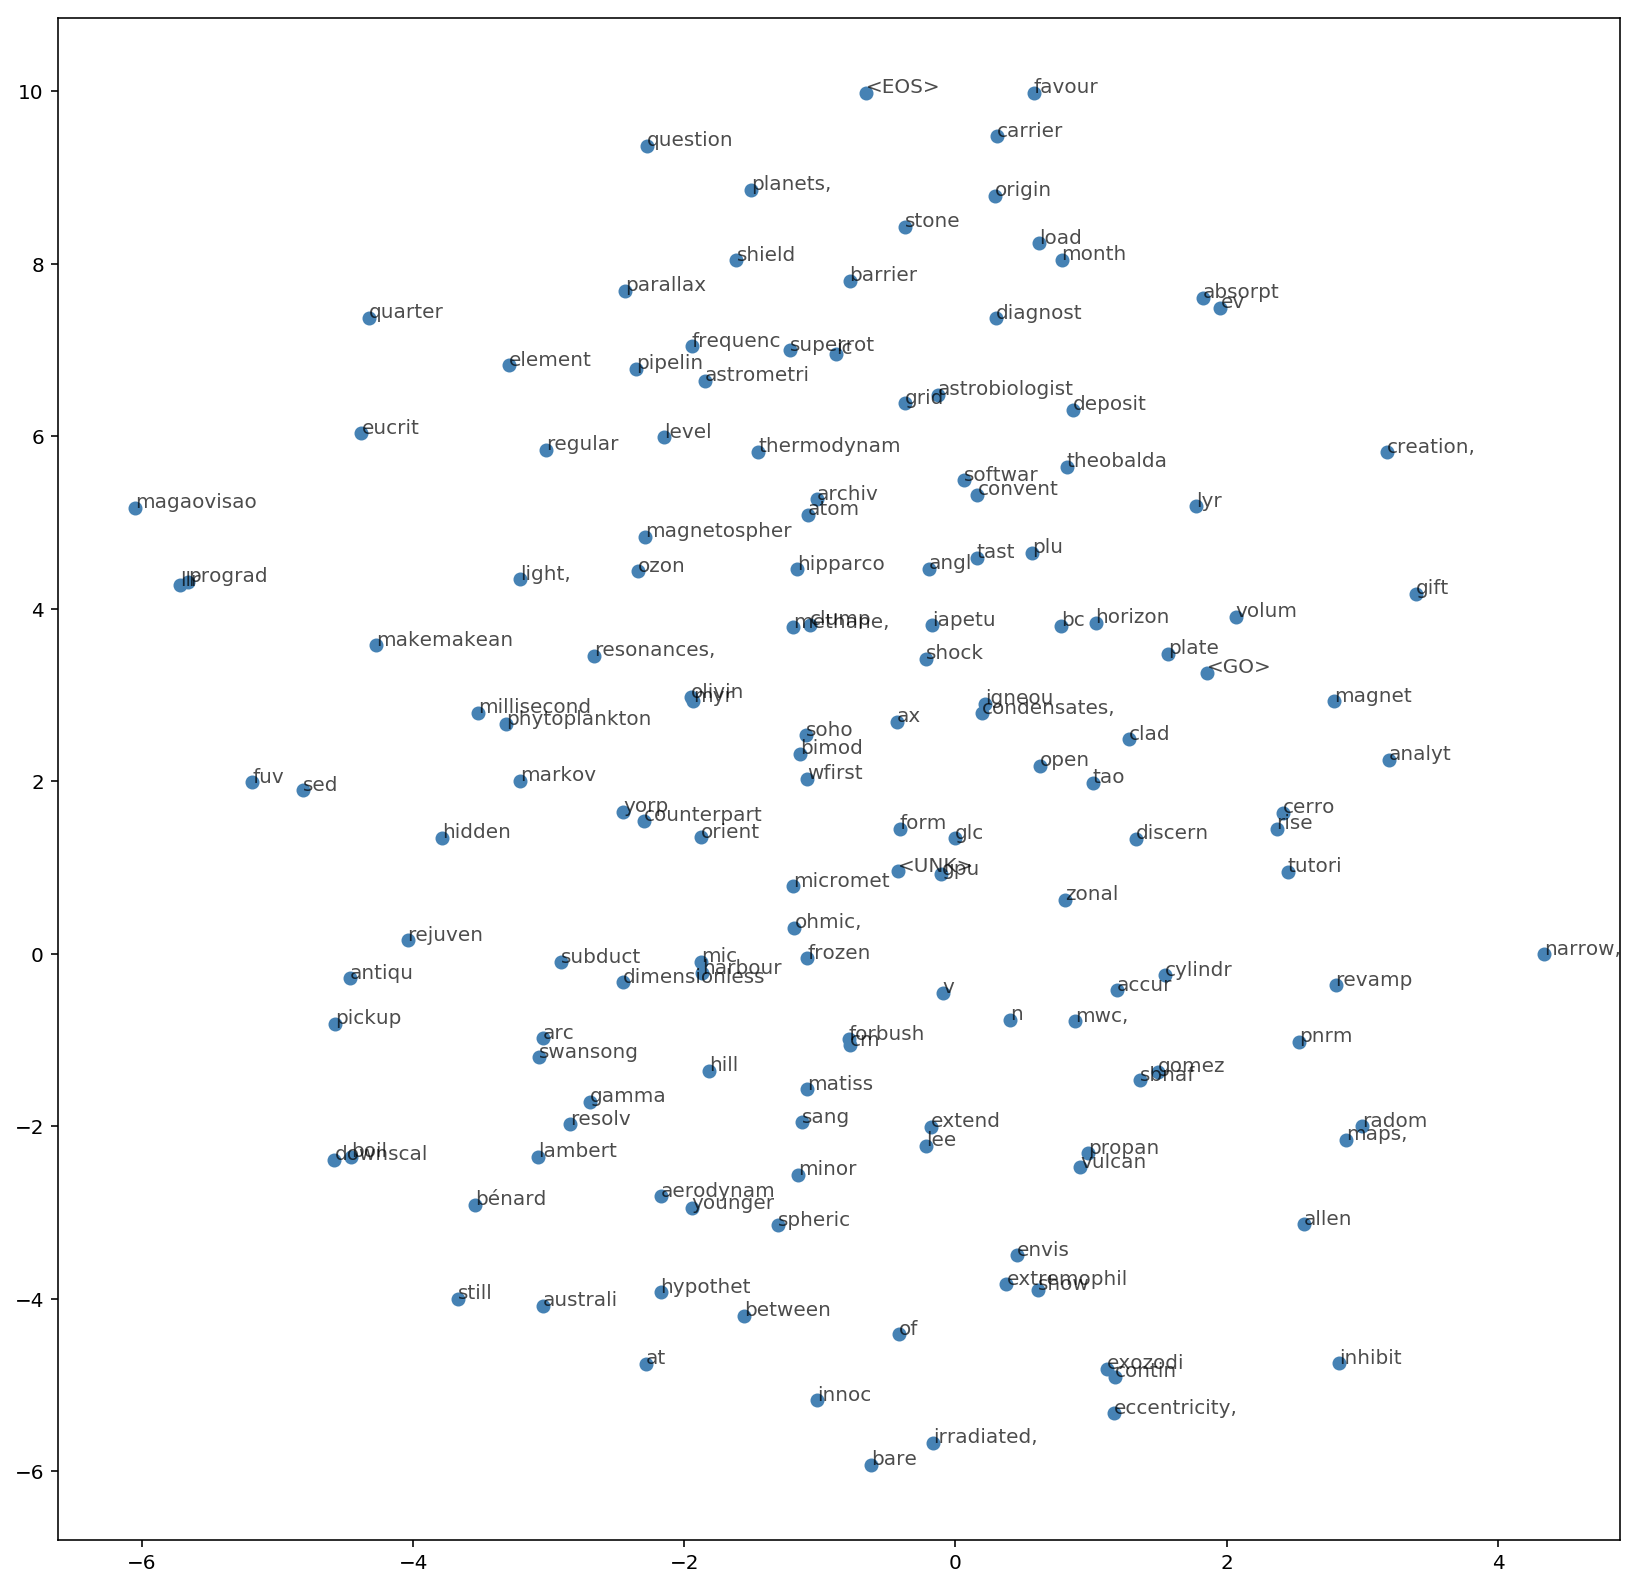

In [88]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
# Plot embedding matrix sample
with train_graph.as_default():
    saver = tf.train.Saver()
    
with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(dec_embeddings)

from sklearn.manifold import TSNE
viz_words = 150
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(1, viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(target_int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)